In [31]:
%pylab inline

import pandas as pd
import numpy as np

from itertools import combinations

from sklearn.metrics import roc_curve, auc, roc_auc_score

from calendar import monthrange
from datetime import datetime, date, timedelta

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [32]:
# import given data
date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")

train = pd.read_csv('../input/train.csv', parse_dates=['Date'], date_parser=date_parser)[['Date', 'Address', 'Species', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos', 'WnvPresent']]
test = pd.read_csv('../input/test.csv', parse_dates=['Date'], date_parser=date_parser)[['Id', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy']]

weather = pd.read_csv('../input/weather.csv', index_col=1, parse_dates=['Date'], date_parser=date_parser)[['Station', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed']]

In [74]:
labels = pd.Series(train['WnvPresent'].values.astype(int), index=train.index)

# pull some training data
X_train = pd.DataFrame(index=train.index)
X_train['Week'] = train.Date.apply(lambda d: d.isocalendar()[1])
X_train['Year'] = train.Date.apply(lambda d: d.year)
X_train['Species'] = train.Species
X_train['NumMosquitos'] = train.NumMosquitos
X_train['WnvPresent'] = train.WnvPresent

species = pd.unique(X_train['Species'])
weeks = pd.unique(X_train['Week'])

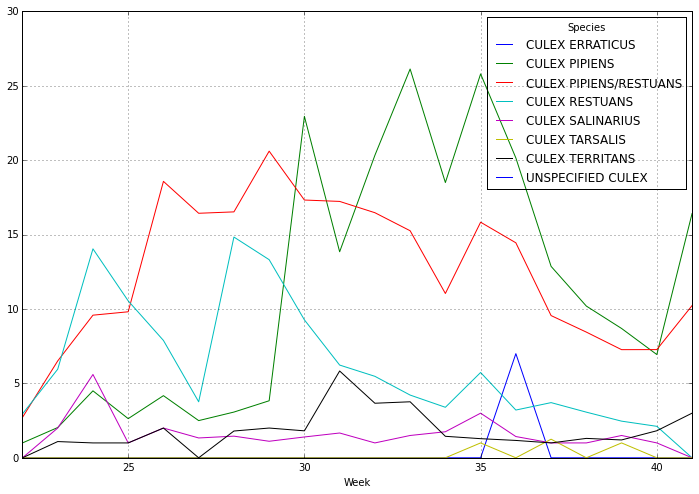

In [75]:
# num mosquitos by week
g_num = X_train.groupby(['Species',  'Week'])['NumMosquitos'].agg(np.mean)
df_num = g_num.unstack(level=[0])
df_num.fillna(0.0, inplace='True')
df_num['UNSPECIFIED CULEX'] = 0.0
df_num.plot(kind='line', figsize=(12, 8))

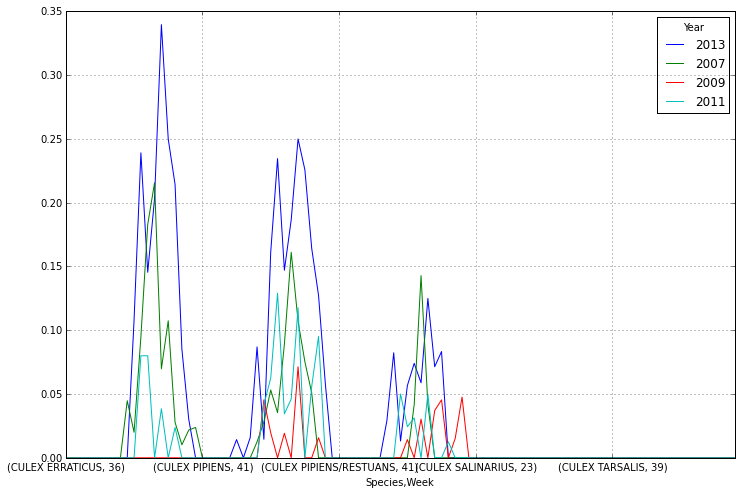

In [108]:
# wnv by week
g_wnv = X_train.groupby(['Species', 'Year', 'Week'])['WnvPresent'].agg(np.mean)
df_wnv = g_wnv.unstack(level=[1])
df_wnv.fillna(0.0, inplace='True')
#df_wnv['UNSPECIFIED CULEX'] = 0.0
df_wnv.plot(kind='line', figsize=(12, 8))

In [77]:
# pull some training data
X_test = pd.DataFrame(index=test.index)
X_test['Week'] = test.Date.apply(lambda d: d.isocalendar()[1])
X_test['Species'] = test.Species

In [78]:
#proba = [df_wnv.loc[row['Week'], row['Species']] for index, row in X_test.iterrows()]
#wnv_test = pd.read_csv('../working/test_f.csv', index_col=0)
#wnv_test['NumMosquitos'] = [df_num.loc[row['Week'], row['Species']] for index, row in X_test.iterrows()]

In [79]:
#import datetime, time
#st = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M%S')

#def write_preds(proba, fname):
#    pd.DataFrame({"Id": list(range(1,len(proba)+1)), "WnvPresent": proba}).to_csv(fname, index=False, header=True)

#write_preds(proba, "../working/exploring_dw_" + st + ".csv")

In [80]:
#wnv_test.to_csv('../working/test_fn.csv')

In [81]:
# validation test
years = np.unique(X_train['Year'])

# combinations approach
yc = list(combinations(years, 3))
train_years = [list(c) for c in yc]
#test_years = [list(set(years) - set(c)) for c in yc]
print train_years

[[2007, 2009, 2011], [2007, 2009, 2013], [2007, 2011, 2013], [2009, 2011, 2013]]


['CULEX ERRATICUS']
[]
AUC validating with year(s) [2013]: 0.730412171787
[]
[]
AUC validating with year(s) [2011]: 0.743299159265
[]
[]
AUC validating with year(s) [2009]: 0.743297144206
[]
[41]
AUC validating with year(s) [2007]: 0.744965627593


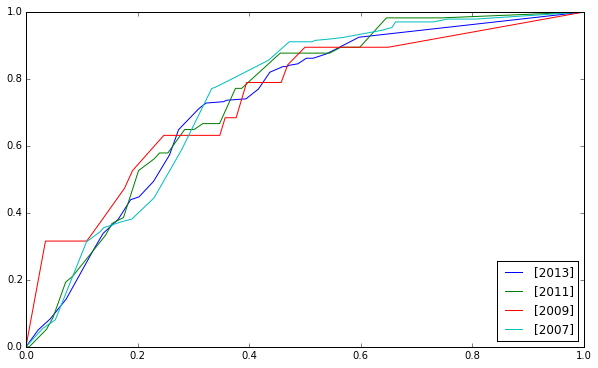

In [101]:
plt.figure(figsize=(10,6))
# iterate through years
for ty in train_years:
    # inverse of year list
    yt = list(set(years) - set(ty))
    
    # get raw data
    train_mask = X_train['Year'].isin(ty)
    test_mask = X_train['Year'].isin(yt)
    Xr_train = X_train[train_mask]
    Xr_test = X_train[test_mask]
    y_train = labels.loc[train_mask].values
    y_test = labels.loc[test_mask].values
    
    # wnv by week
    g_wnv = Xr_train.groupby(['Species', 'Week'])['WnvPresent'].agg(np.mean)
    df_wnv = g_wnv.unstack(level=[0])
    
    ns = list(set(species) - set(pd.unique(Xr_train['Species'])))
    print ns
    #df_wnv[list(set(species) - set(pd.unique(Xr_train['Species'])))] = 0.0
    for s in ns:
        df_wnv[s] = 0.0
    
    nw = list(set(weeks) - set(pd.unique(Xr_train['Week'])))
    print nw
    for w in nw:
        df_wnv.loc[w] = 0.0
    
    df_wnv.fillna(0.0, inplace='True')
    
    # predict labels
    proba = [df_wnv.loc[row['Week'], row['Species']] for index, row in Xr_test.iterrows()]
    
    # metrics
    fpr, tpr, thresholds = roc_curve(y_test, proba)
    score = auc(fpr, tpr)
    print 'AUC validating with year(s)', str(yt) + ':', score
    
    # plot
    plt.plot(fpr, tpr, label=yt)

plt.legend(loc=4)

In [100]:
df_wnv.loc[41] = 0.0
print df_wnv

Species  CULEX ERRATICUS  CULEX PIPIENS  CULEX PIPIENS/RESTUANS  \
22                     0       0.000000                0.000000   
23                     0       0.000000                0.000000   
24                     0       0.000000                0.000000   
25                     0       0.000000                0.000000   
26                     0       0.000000                0.004673   
27                     0       0.000000                0.000000   
28                     0       0.000000                0.005376   
29                     0       0.000000                0.039409   
30                     0       0.000000                0.035019   
31                     0       0.036036                0.081081   
32                     0       0.125000                0.134328   
33                     0       0.101010                0.073034   
34                     0       0.169014                0.121429   
35                     0       0.182692                0.14691